# Modeling Fe XIX and Fe XII Emission with EBTEL

In [32]:
from imp import reload
import os,sys
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src'))
import ebtel_plot as ebp
import em_binner as emb
import chianti.core as ch
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
%matplotlib inline
reload(emb)
reload(ch)

<module 'chianti.core' from '/opt/anaconda3/lib/python3.4/site-packages/chianti/core/__init__.py'>

In [Brosius et al. (2014)](http://adsabs.harvard.edu/abs/2014ApJ...790..112B), the authors diagnose the existence of hot plasma thought to be created by impulsive heating (i.e. "nanoflares") by computing the intensity ratio between Fe XIX ($T\approx8.9$ MK) and Fe XII ($T\approx1.6$ MK).

| Ion | Wavelength (angstrom) | Peak Temperature (MK) |
|:----:|:------------------:|:---------------------:|
| Fe XII | 592.6 | 1.6 |
| Fe XIX | 592.2 | 8.9 |

Here, we will do the same using our impulsively heated 0D loops from EBTEL.

## Calculating intensity
The intensity for a particular transition can be calculated using the expression
$$
I(\lambda_{j,g})=\frac{0.83\mathrm{Ab}(X)hc}{4\pi\lambda_{j,g}R^2}\int_V\mathrm{d}T\,\mathrm{DEM}(T)G(T,\lambda_{j,g})
$$
For now, we will only focus on the integrand. 

First, we need to calculate the contribution functions 

### Contribution Functions, $G(T,\lambda)$

In [47]:
trange=np.logspace(5.5,8,100)
nrange=4.3e+9

In [48]:
fe12=ch.ion('fe_12',temperature=trange,eDensity=nrange)
fe19=ch.ion('fe_19',temperature=trange,eDensity=nrange)

 ndens =     1 ntemp =   100
 - make a selection from these - 
     0     592.6000    6   17 3s 3p4 4P2.5 - 3s2 3p2 3d 4F4.5 
     1     592.6940  394  545 3s2 3p2 4p 2P1.5 - 3s2 3p2 4d 2F2.5 
     2     592.9640  656  896 3s 3p3 4p 4D2.5 - 3s 3p3 4d 2P1.5 
 type the comma-separated index/indices of your selection
>>> 0


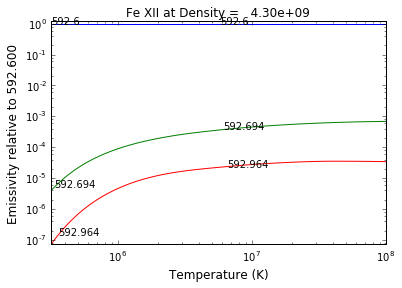

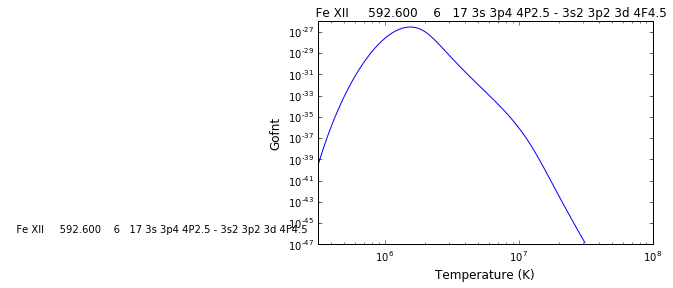

In [49]:
fe12.gofnt(wvlRange=[592,593],top=3)

 ndens =     1 ntemp =   100
 - make a selection from these - 
     0     592.2350    1    4 2s22p4 3P2.0 - 2s22p4 1D2.0 
 type the comma-separated index/indices of your selection
>>> 0


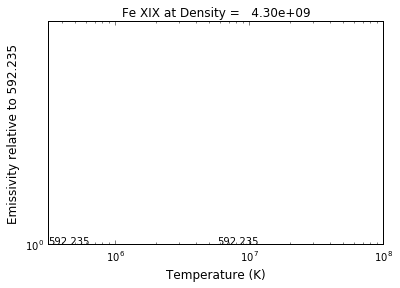

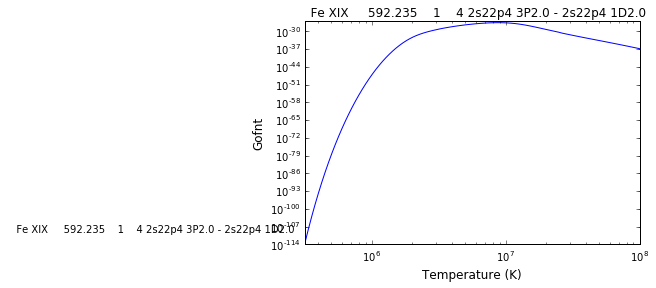

In [50]:
fe19.gofnt(wvlRange=[592,593],top=3)

### Calculating the DEM

Now, let's load a sample EBTEL run and calculate the DEM at each timestep $t_i$

In [130]:
sample_ebtel_run=np.loadtxt('/data/datadrive2/EBTEL_runs/ion_heating_runs/alpha1.5/data/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4/ebtel_L40.0_tn5000-b1.0_tpulse200.0_rka4_0.txt')
t=sample_ebtel_run[:,0]
Te=sample_ebtel_run[:,1]
n=sample_ebtel_run[:,3]

In [131]:
sample_em_binner=emb.EM_Binner(2.*4e+9,time=t,temp=Te,density=n)

In [132]:
sample_em_binner.build_em_dist(build_mat=True)

Now that we have the temperature range over which the DEM is being calculated, we can interpolate the contribution function $G(T)$ over this temperature range.

In [133]:
g_interpolator_fe12=sc.interpolate.splrep(fe12.Gofnt['temperature'],fe12.Gofnt['gofnt'])
g_interpolator_fe19=sc.interpolate.splrep(fe19.Gofnt['temperature'],fe19.Gofnt['gofnt'])

In [134]:
safe_indices_fe12=np.where((sample_em_binner.T_em>np.min(fe12.Gofnt['temperature'])) & (sample_em_binner.T_em<np.max(fe12.Gofnt['temperature'])))
safe_indices_fe19=np.where((sample_em_binner.T_em>np.min(fe19.Gofnt['temperature'])) & (sample_em_binner.T_em<np.max(fe19.Gofnt['temperature'])))

In [135]:
g_fe12,g_fe19=np.zeros(len(sample_em_binner.T_em)),np.zeros(len(sample_em_binner.T_em))

In [136]:
g_fe12[safe_indices_fe12[0]]=sc.interpolate.splev(sample_em_binner.T_em[safe_indices_fe12[0]],g_interpolator_fe12)
g_fe19[safe_indices_fe19[0]]=sc.interpolate.splev(sample_em_binner.T_em[safe_indices_fe19[0]],g_interpolator_fe19)

In [137]:
intensity_fe12,intensity_fe19=np.zeros(len(t)),np.zeros(len(t))
for i in range(len(t)):
    intensity_fe12[i]=np.log(10)*sample_em_binner.delta_logT*np.sum(sample_em_binner.T_em*g_fe12*sample_em_binner.dem_mat[i,:])
    intensity_fe19[i]=np.log(10)*sample_em_binner.delta_logT*np.sum(sample_em_binner.T_em*g_fe19*sample_em_binner.dem_mat[i,:])

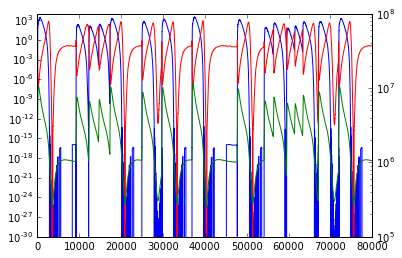

In [139]:
fig=plt.figure()
ax=fig.gca()
ax2=ax.twinx()
ax.plot(t,intensity_fe19,'b')
ax.set_yscale('log')
ax.plot(t,intensity_fe12,'r')
ax2.plot(t,Te,'g')
ax2.set_yscale('log')
#ax.set_xscale('log')
#ax2.set_xscale('log')
#ax2.set_xlim([0,1e+4])
#ax.set_xlim([0,1e+4])

In [140]:
intensity_fe12[intensity_fe12<1e-2]=0.
np.average(intensity_fe12,weights=np.gradient(t))

25.369419438084279

In [141]:
intensity_fe19[intensity_fe19<1e-2]=0.
np.average(intensity_fe19,weights=np.gradient(t))

107.9677882752981

(0, 10000.0)

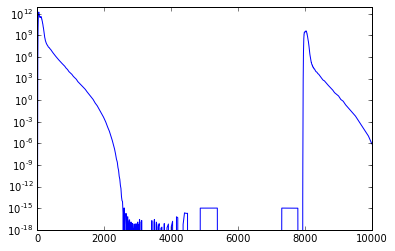

In [125]:
plt.plot(t,intensity_fe19/intensity_fe12)
plt.yscale('log')
plt.xlim([0,1e+4])